<center>

# Групповой проект
</center>

Цель - создание модели оценки справедливой стоимости квартир в Екатеринбурге.

## Шаг 3: предварительныя обработка

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_excel('output.xlsx')
df.head()

,author,link,city,deal_type,accommodation_type,floor,floors_count,rooms_count,total_meters,price,year_of_construction,living_meters,kitchen_meters,phone,district,street,underground,residential_complex
0,TEN девелопмент,https://ekb.cian.ru/sale/flat/282900962/,Екатеринбург,sale,flat,1,31,1,30.60,3673800,2023,14.0,7.0,73432261182,Чкаловский,Светлый мкр,Ботаническая,Светлый
1,TEN девелопмент,https://ekb.cian.ru/sale/flat/255177069/,Екатеринбург,sale,flat,25,31,1,35.80,5284000,2023,12.0,12.0,73432261244,Ленинский,Академика Бардина,Чкаловская,Дом на Бардина
2,Эталон,https://ekb.cian.ru/sale/flat/283487334/,Екатеринбург,sale,flat,14,25,1,37.99,4835128,2022,16.0,11.0,73432267743,Октябрьский,Южный жилрайон,Ботаническая,Суомен Ранта ЖК
3,TEN девелопмент,https://ekb.cian.ru/sale/flat/284939234/,Екатеринбург,sale,flat,2,19,1,32.50,4106000,2025,10.0,10.0,73432261243,Орджоникидзевский,Учителей,Машиностроителей,Основинские кварталы
4,Эталон,https://ekb.cian.ru/sale/flat/279479083/,Екатеринбург,sale,flat,14,16,1,42.00,4158074,2022,8.0,21.0,73432260512,NaN,NaN,Проспект Космонавтов,NaN


Посмотрим на наши данные в целом: какой размер датасета, какие есть столбцы и какие типы данных в них содержатся, сколько пропусков.

In [3]:
print(df.shape)
pd.concat([df.dtypes, df.isna().sum()], axis=1, keys=['dtypes', 'missing'])

(4197, 18)


,dtypes,missing
author,object,266
link,object,0
city,object,0
deal_type,object,0
accommodation_type,object,0
floor,int64,0
floors_count,int64,0
rooms_count,int64,0
total_meters,float64,0
price,int64,0


У нас есть следующие колонки:

- Автор объявления

- Ссылка на объявление

- Город

- Тип сделки

- Тип недвижимости

- Этаж

- Общее количество этажей

- Количество комнат

- Общая площадь

- Стоимость

- Год постройки

- Жилая площадь

- Площадь кухни

- Номер телевона автора объявления

- Район

- Улица

- Ближайшее метро

- Название жилого комплекса

В ходе работы нам вряд ли понадобится следующая информация: ссылка на объявление, город (мы работаем только с недвижимостью Екатеринбурга), тип сделки (у нас везде продажа), тип недвижимости (мы работаем только с квартирами), количество комнат (мы рассматриваем только студии и однушки, то есть везде будет одна), номер телефона, улица, название жилого комплекса. Удалим эти колонки.

In [4]:
df = df.drop(['link', 'city', 'deal_type', 'accommodation_type', 'rooms_count', 
              'phone', 'residential_complex'], axis=1)
df.head()

,author,floor,floors_count,total_meters,price,year_of_construction,living_meters,kitchen_meters,district,street,underground
0,TEN девелопмент,1,31,30.60,3673800,2023,14.0,7.0,Чкаловский,Светлый мкр,Ботаническая
1,TEN девелопмент,25,31,35.80,5284000,2023,12.0,12.0,Ленинский,Академика Бардина,Чкаловская
2,Эталон,14,25,37.99,4835128,2022,16.0,11.0,Октябрьский,Южный жилрайон,Ботаническая
3,TEN девелопмент,2,19,32.50,4106000,2025,10.0,10.0,Орджоникидзевский,Учителей,Машиностроителей
4,Эталон,14,16,42.00,4158074,2022,8.0,21.0,NaN,NaN,Проспект Космонавтов


Теперь поработаем с колонками, где у нас есть пропуски, попробуем заполнить их.

Начнем с автора объявления.

In [5]:
print(df['author'].value_counts().to_string(max_rows=None))

TEN девелопмент                                  746
Эталон                                           302
Брусника                                         258
Диал                                             158
Новосёл                                          157
АЗБУКА НЕДВИЖИМОСТИ                              154
ID 70812476                                      150
Этажи Нижний Тагил                               129
ПИК                                              109
Прогресс                                         101
ID 70812431                                       97
ID 96546420                                       97
Академический                                     79
Fortis Development                                72
Стройтэк                                          66
Этажи Екатеринбург                                64
ЛСР. Недвижимость                                 59
Корпорация Маяк                                   53
Самолет Плюс Екатеринбург                     

Нам скорее интересен не сам автор объявления, а является ли он частным собственником или работает через посредника-агентство недвижимости / является застройщиком. Создадим новую колонку *owner* и заполним её False, если от автора есть более одного объявления, и True, в остальных случаях (пропуски тоже). После удалим колонку *author*.

In [6]:
df['owner'] = df['author'].duplicated(keep=False).apply(lambda x: not x)
df.loc[df['author'].isna(), 'owner'] = True
df = df.drop(['author'], axis=1)
df.head()

,floor,floors_count,total_meters,price,year_of_construction,living_meters,kitchen_meters,district,street,underground,owner
0,1,31,30.60,3673800,2023,14.0,7.0,Чкаловский,Светлый мкр,Ботаническая,False
1,25,31,35.80,5284000,2023,12.0,12.0,Ленинский,Академика Бардина,Чкаловская,False
2,14,25,37.99,4835128,2022,16.0,11.0,Октябрьский,Южный жилрайон,Ботаническая,False
3,2,19,32.50,4106000,2025,10.0,10.0,Орджоникидзевский,Учителей,Машиностроителей,False
4,14,16,42.00,4158074,2022,8.0,21.0,NaN,NaN,Проспект Космонавтов,False


Теперь рассмотрим колонку *district*.

In [7]:
df['district'].value_counts()

Ленинский                                                                                                                583
Верх-Исетский                                                                                                            540
Чкаловский                                                                                                               456
Кировский                                                                                                                402
Октябрьский                                                                                                              382
Орджоникидзевский                                                                                                        365
Центр                                                                                                                    278
Железнодорожный                                                                                                          276


Нам нужно сначала привести к нормальному виду район Солнечный. Наблюдения с районами Красногорский, Сысертский, Белоярский можно удалить, т.к. там мало наблюдений.

In [8]:
df['district'] = df['district'].apply(lambda x: 'Солнечный' if isinstance(x, str) and 'Солнечный' in x else x)
df.drop(df.loc[df['district'] == 'Красногорский'].index, inplace=True)
df.drop(df.loc[df['district'] == 'Синарский'].index, inplace=True)
df.drop(df.loc[df['district'] == 'уютная квартира в Сысертском е'].index, inplace=True)
df.drop(df.loc[df['district'] == '2 кв. м. в Посёлке городского типа Белоярский.\n\nРАЙОН:\nБелоярский .\n\nДВОР:\nОборудован детской игровой площадкой'].index, inplace=True)

df['district'].value_counts()

Ленинский            583
Верх-Исетский        540
Чкаловский           456
Кировский            402
Октябрьский          382
Орджоникидзевский    365
Центр                278
Железнодорожный      276
Автовокзал           225
Тагилстроевский       55
Дзержинский           24
Солнечный             11
Name: district, dtype: int64

Теперь займемся пропусками. Создадим подтаблицу только со строками, где в нашем столбце пропуск.

In [9]:
df_no_district = df.loc[df['district'].isna()]
print(df_no_district.shape)
df_no_district.isna().sum()

(595, 11)


floor                     0
floors_count              0
total_meters              0
price                     0
year_of_construction      0
living_meters             0
kitchen_meters            0
district                595
street                  595
underground             408
owner                     0
dtype: int64

Тут можно заметить, что даже если отсутствует район, у многих наблюдений есть информация о метро. Попробуем воспользоваться этой информацией. Сначала удалим все строки, где неизвестно ни метро, ни район.

In [10]:
df.dropna(subset=['district', 'underground'], how='all', inplace=True)
df.shape

(3784, 11)

Теперь, если мы знаем, какое метро у квартиры, мы можем посмотреть, какой район чаще всего указывают для этого метро и заполнить пропуски по недостающим районам. В обратную сторону мы так не можем сделать, так как пропуск в столбце *underground* может просто указывать на то, что рядом метро нет.

In [11]:
# создаем словарь для хранения самых популярных значений district для каждого значения underground
underground_districts = {}

# проходим по каждому уникальному значению в столбце 'underground'
for underground in df['underground'].unique():
    # получаем все наблюдения с заданным значением в столбце 'underground'
    mask = df['underground'] == underground
    # получаем список значений 'district' для заданного значения 'underground'
    districts = df.loc[mask, 'district']
    # находим самое популярное значение 'district' для заданного значения 'underground'
    if len(districts) > 0:
        most_common_district = districts.mode().values[0]
        # добавляем значение 'most_common_district' в словарь для заданного значения 'underground'
        underground_districts[underground] = most_common_district

# заменяем пропущенные значения в столбце 'district'
for i, row in df.iterrows():
    # проверяем, является ли значение в столбце 'district' пропущенным
    if pd.isna(row['district']):
        # получаем значение в столбце 'underground' для данной строки
        underground = row['underground']
        # находим самое популярное значение 'district' для данного значения 'underground'
        if underground in underground_districts:
            most_common_district = underground_districts[underground]
            # заменяем пропущенное значение в столбце 'district' на самое популярное значение 'district'
            df.at[i, 'district'] = most_common_district

Как уже было сказано, пропуски в столбце с метро не являются по сути своей пропусками, это лишь значит, что поблизости нет метро. Так и запишем в датафрейме.

In [12]:
df['underground'] = df['underground'].fillna('Нет метро')

In [13]:
df

,floor,floors_count,total_meters,price,year_of_construction,living_meters,kitchen_meters,district,street,underground,owner
0,1,31,30.60,3673800,2023,14.0,7.0,Чкаловский,Светлый мкр,Ботаническая,False
1,25,31,35.80,5284000,2023,12.0,12.0,Ленинский,Академика Бардина,Чкаловская,False
2,14,25,37.99,4835128,2022,16.0,11.0,Октябрьский,Южный жилрайон,Ботаническая,False
3,2,19,32.50,4106000,2025,10.0,10.0,Орджоникидзевский,Учителей,Машиностроителей,False
4,14,16,42.00,4158074,2022,8.0,21.0,Орджоникидзевский,NaN,Проспект Космонавтов,False
...,...,...,...,...,...,...,...,...,...,...,...
4192,7,9,32.30,3650000,1974,18.0,7.0,Орджоникидзевский,Электриков,Машиностроителей,False
4193,10,24,42.40,5123361,2023,15.0,16.0,Октябрьский,Южный жилрайон,Ботаническая,False
4194,6,24,33.30,4550000,2023,11.0,10.0,Октябрьский,Южный жилрайон,Ботаническая,False
4195,2,24,39.69,5600000,2025,-1.0,17.0,Ленинский,NaN,Чкаловская,False


In [14]:
df.street.isna().sum()

1215

In [15]:
df.street.value_counts()

Южный жилрайон           256
Светлый мкр              129
Учителей                 103
Академика Бардина        102
Советская                101
                        ... 
Карла Либкнехта            1
Патона                     1
Софьи Ковалевской          1
Подгорная                  1
переулок Асбестовский      1
Name: street, Length: 282, dtype: int64

Посмотрим еще раз внимательно на датасет

In [16]:
df.describe()

,floor,floors_count,total_meters,price,year_of_construction,living_meters,kitchen_meters
count,3784.000000,3784.000000,3784.000000,3.784000e+03,3784.000000,3784.000000,3784.000000
mean,8.145877,18.443446,44.032479,4.956469e+06,1987.360994,9.894080,8.982796
std,7.332903,8.400872,34.457797,2.187324e+06,235.474244,8.365313,7.305833
min,1.000000,1.000000,10.700000,5.700000e+05,-1.000000,-1.000000,-1.000000
25%,2.000000,10.000000,32.600000,3.870000e+06,2022.000000,-1.000000,-1.000000
50%,6.000000,19.000000,36.400000,4.568814e+06,2023.000000,11.000000,10.000000
75%,11.000000,25.000000,42.400000,5.600000e+06,2024.000000,15.100000,15.000000
max,35.000000,37.000000,333.400000,3.870000e+07,2026.000000,233.000000,55.000000


В столбцах *year_of_construction, living_meters, kitchen_meters* есть значения равные -1. В документация библиотеки написано, что это тоже пропуски. Так как здесь мы работаем уже с цифрами, то логичнее всего заполнить пропуски медианой. Но перед этим надо удалить минус единицы из её рассчета.

In [17]:
# заменяем все значения равные -1 на NaN
df = df.replace(-1, np.nan)

# вычисляем медианы столбцов, исключая NaN значения
medians = df.median(skipna=True)

# заменяем все NaN значения в каждом столбце на соответствующую медиану
for col in ['year_of_construction', 'living_meters', 'kitchen_meters']:
    df[col] = df[col].fillna(medians[col])

In [18]:
df.isna().sum()

floor                      0
floors_count               0
total_meters               0
price                      0
year_of_construction       0
living_meters              0
kitchen_meters             0
district                   0
street                  1215
underground                0
owner                      0
dtype: int64

In [19]:
df.shape

(3784, 11)

Теперь удалим выбросы по колонкам общей, жилой, кухонной площади, а также цены. Будем использвать Z-score со значением 3, то есть данные должны отклоняться от среднего не более чем на 3 стандартных отклонения.

In [20]:
def remove_outliers_zscore(df, columns, threshold):
    # создаем копию датафрейма
    df_clean = df.copy()

    # итерируемся по столбцам
    for col in columns:
        # вычисляем Z-оценку для каждого значения в столбце
        z_scores = np.abs(stats.zscore(df_clean[col]))

        # создаем маску, чтобы выбрать только значения, которые не являются выбросами
        mask = z_scores < threshold

        # заменяем значения в столбце на NaN, если они являются выбросами
        df_clean.loc[~mask, col] = np.nan

    # удаляем строки с пропущенными значениями
    df_clean.dropna(inplace=True)

    return df_clean

In [21]:
# удаляем выбросы из столбцов с порогом 3
df = remove_outliers_zscore(df, ['total_meters', 'living_meters', 'kitchen_meters', 'price'], 3)
df.shape

(2486, 11)

In [22]:
df.isna().sum()

floor                   0
floors_count            0
total_meters            0
price                   0
year_of_construction    0
living_meters           0
kitchen_meters          0
district                0
street                  0
underground             0
owner                   0
dtype: int64

In [23]:
df.describe()

,floor,floors_count,total_meters,price,year_of_construction,living_meters,kitchen_meters
count,2486.000000,2486.000000,2486.000000,2.486000e+03,2486.000000,2486.000000,2486.00000
mean,9.292840,18.549477,35.998347,4.699452e+06,2010.670555,14.487088,11.50897
std,7.908043,9.131179,6.988035,1.804027e+06,21.612884,3.215549,4.08832
min,1.000000,1.000000,10.700000,5.700000e+05,1917.000000,3.000000,3.00000
25%,3.000000,9.000000,32.300000,3.650000e+06,2011.000000,12.000000,8.00000
50%,6.000000,19.000000,35.800000,4.431504e+06,2023.000000,14.000000,12.00000
75%,14.000000,25.000000,41.400000,5.284000e+06,2023.000000,16.000000,13.00000
max,35.000000,37.000000,80.000000,1.009900e+07,2025.000000,29.000000,25.00000


In [24]:
df['year_of_construction'] = df['year_of_construction'].astype(int)

Кажется, стало лучше.

## Шаг 4: визуализация

In [25]:
df.head()

,floor,floors_count,total_meters,price,year_of_construction,living_meters,kitchen_meters,district,street,underground,owner
0,1,31,30.60,3673800.0,2023,14.0,7.0,Чкаловский,Светлый мкр,Ботаническая,False
1,25,31,35.80,5284000.0,2023,12.0,12.0,Ленинский,Академика Бардина,Чкаловская,False
2,14,25,37.99,4835128.0,2022,16.0,11.0,Октябрьский,Южный жилрайон,Ботаническая,False
3,2,19,32.50,4106000.0,2025,10.0,10.0,Орджоникидзевский,Учителей,Машиностроителей,False
8,5,7,41.40,9251000.0,2024,12.0,13.0,Центр,Азина,Динамо,False


Для начала посмотрим как тип продавца влияет на год постройки дома.

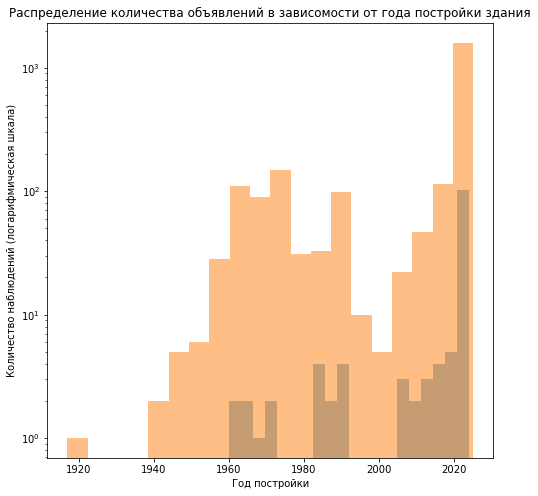

In [26]:
# разделяем DataFrame по значению столбца owner
df_owner_true = df[df['owner'] == True]
df_owner_false = df[df['owner'] == False]

plt.figure(figsize=(8,8))

# строим гистограмму для значений True
plt.hist(df_owner_true['year_of_construction'], bins=20, alpha=0.5, label='owner=True', log=True)

# строим гистограмму для значений False
plt.hist(df_owner_false['year_of_construction'], bins=20, alpha=0.5, label='owner=False', log=True)

plt.title('Распределение количества объявлений в зависомости от года постройки здания')
plt.xlabel('Год постройки')
plt.ylabel('Количество наблюдений (логарифмическая шкала)')
plt.show()

Чего-то интересного из этого графика выявить не получилось, лишь только тот факт, что от частных собственников нет объявлений о продаже квартир в зданиях, построенных ранее 1960 года, а большинство квартир продается в новых домах.

Также интересно посмотреть, как этажность домов зависит от года постройки. Стали ли в Екатеринбурге строить более высокие дома?

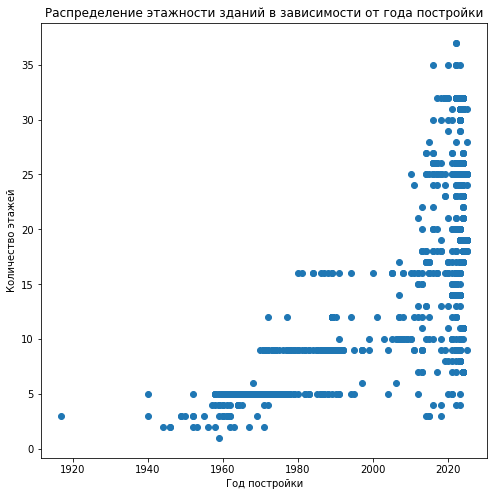

In [27]:
plt.figure(figsize=(8,8))
plt.scatter(df['year_of_construction'], df['floors_count'])
plt.title('Распределение этажности зданий в зависимости от года постройки')
plt.xlabel('Год постройки')
plt.ylabel('Количество этажей')
plt.show()

Кажется стали, да. Начиная с нулевых этажность выросла в 2 раза.

А зависит ли этажность от района?

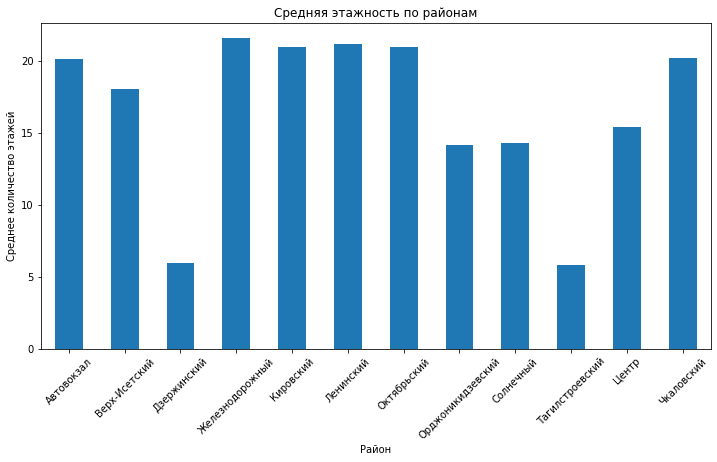

In [28]:
df_grouped = df.groupby('district')['floors_count'].mean()

df_grouped.plot(kind='bar', figsize=(12,6))
plt.title('Средняя этажность по районам')
plt.xlabel('Район')
plt.ylabel('Среднее количество этажей')
plt.xticks(rotation=45)

plt.show()

На этом графике сразу видны районы со старой застройкой, странно, что центр таким не является.

Теперь посмотрим тоже самое для станций метро. Кажется, что если метро нет рядом, то в таком случае этажность должна быть самая низкая.

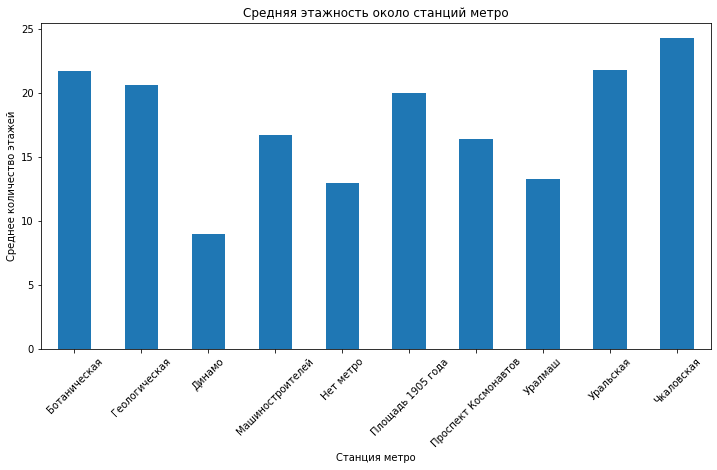

In [29]:
df_grouped = df.groupby('underground')['floors_count'].mean()

df_grouped.plot(kind='bar', figsize=(12,6))
plt.title('Средняя этажность около станций метро')
plt.xlabel('Станция метро')
plt.ylabel('Среднее количество этажей')
plt.xticks(rotation=45)

plt.show()

На удивление, нет. Около станции Динамо этажность ниже, чем средняя у домов в дали от метро.

Посмотрим аналогично год постройки в зависимости от метро.

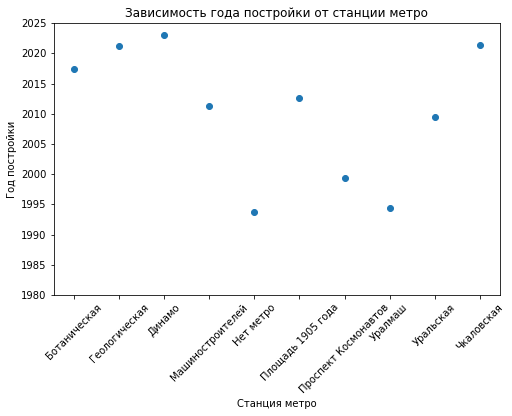

In [30]:
# группируем данные по станциям метро и вычисляем медианное значение года постройки для каждой станции
data = df.groupby('underground')['year_of_construction'].mean()

# создаем график с точками
plt.figure(figsize=(8,5))
plt.scatter(data.index, data.values)

# добавляем заголовок и подписи осей
plt.title('Зависимость года постройки от станции метро')
plt.xlabel('Станция метро')
plt.xticks(rotation=45)
plt.ylabel('Год постройки')
plt.ylim(1980, 2025);

Похоже, зачастую в Екатеринбурге сначала строили метро, а только потом начинали строить вокруг дома. Кроме того, самые новые дома около метро Динамо, при этом же там самая малая этажность. Скорее всего квартиры там дорогие.

Также интересно посмотреть, как зависит площадь кухни от общей площади квартиры. Может будут какие-то особенности?

In [64]:
def round_to_nearest_five(x):
    rounded = round(x)
    remainder = rounded % 5
    if remainder < 2.5:
        return rounded - remainder
    else:
        return rounded + (5 - remainder)

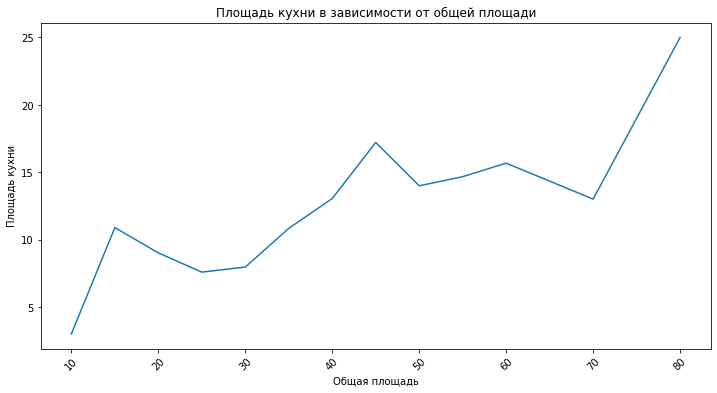

In [65]:
df2 = df.copy()
df2['total_meters'] = round(df2['total_meters'])
df2['total_meters'] = df2['total_meters'].apply(round_to_nearest_five)
df_grouped = df2.groupby('total_meters')['kitchen_meters'].mean()

df_grouped.plot(kind='line', figsize=(12,6))
plt.title('Площадь кухни в зависимости от общей площади')
plt.xlabel('Общая площадь')
plt.ylabel('Площадь кухни')
plt.xticks(rotation=45)

plt.show()

Можно заметить, что средняя площадь кухни в квартирах от 20 до 30 метров меньше, чем в квартирах с площадью около 15 метров. Странно. Посмотрим, может год постройки как-то влиял на планировку?

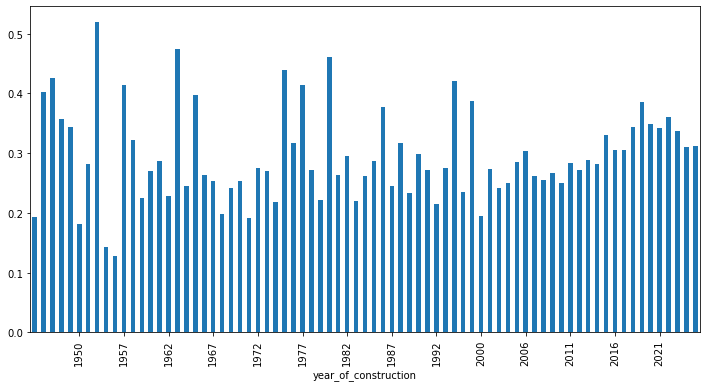

In [67]:
df2 = df.copy()
df2['k'] = df2['kitchen_meters']/df2['total_meters']

df_grouped = df2.groupby('year_of_construction')['k'].mean()
ax = df_grouped.plot(kind='bar', figsize=(12,6))

x_ticks = ax.get_xticks()
ax.set_xticks(x_ticks[5::5])

plt.show()

Да, можно видеть, как в некоторые года доля кухни была аномально высокой.